<a href="https://colab.research.google.com/github/jdariasl/ML_2020/blob/master/Labs/lab5/lab5_parte1.ipynb">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Recuerda que una vez abierto, Da clic en "Copiar en Drive", de lo contrario no podras almacenar tu progreso**

Nota: no olvide ir ejecutando las celdas de código de arriba hacia abajo para que no tenga errores de importación de librerías o por falta de definición de variables.

In [1]:
#configuración del laboratorio
# Ejecuta esta celda!
%load_ext autoreload
%autoreload 2
#for local 
#import sys ; sys.path.append('../commons/utils/')
!wget https://raw.githubusercontent.com/jdariasl/ML_2020/master/Labs/commons/utils/general.py -O general.py --no-cache
from general import configure_lab5_1
configure_lab5_1()
from lab5 import *
GRADER, dataset = part_1()
import neurolab as nl

--2020-11-20 03:15:47--  https://raw.githubusercontent.com/jdariasl/ML_2020/master/Labs/commons/utils/general.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14117 (14K) [text/plain]
Saving to: ‘general.py’

general.py          100%[===================>]  13.79K  --.-KB/s    in 0s      

2020-11-20 03:15:47 (32.6 MB/s) - ‘general.py’ saved [14117/14117]

lab configuration started
installing libraries
downloading files
lab configured


# Laboratorio 5 - Parte 1: Redes recurrentes

En este  laboratorio entrenaremos una Red Neuronal Recurrente para la predicción de una serie de tiempo. 

Este problema corresponde a una configuración many-to-one. 

En este caso usaremos una serie de tiempo que corresponde al número de pasajeros internacionales por mes, desde el año 1949 hasta el año 1960. 

En la siguiente celda visualizamos los datos.

tenemos dispnible nuestra base de datos en el pandas DF 'dataset' 



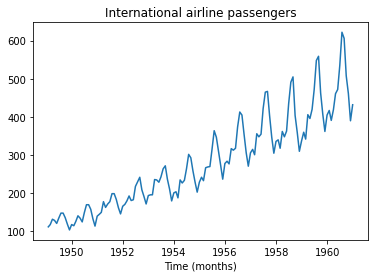

In [2]:
# creamos una variable para
# el tiempo
Time = pd.date_range(np.datetime64('1949-01'), np.datetime64('1961-01'), freq='M')
print("tenemos dispnible nuestra base de datos en el pandas DF 'dataset' \n")
plt.plot(Time,dataset)
plt.title('International airline passengers')
plt.xlabel('Time (months)')
plt.show()

En nuestro primer ejercicio vamos a explorar, que relación existe entre una muestra con las muestras inmediantamente pasadas.La libreria statsmodel [tiene una función que nos sirve para analizar esta relación](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html).


## Ejercicio 1 - Exploración del problema

Este plot realiza una operación cuyos detalles son explicados en mayor profundidad en [esta buena entrada de blog](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/). Pero nuestro laboratorio lo que no interesa es entender:

1. El valor varia entre 1.0 y -1.0. 
2. Cuando el valor de la correlación es 1.0, corresponde el valor maximo indicando una relación positiva entre la variable y su correspondiente lag o retraso.
3. Cuando el valor de la correlación es -1.0, corresponde el valor mínimo indicando una relación negativa entre la variable y su correspondiente lag o retraso..
4. 0.0 indica que los valores no están relacionados.
5. el lag indica, el número de retrasos. Si el valor de la correlación en el lag  5 es igual 0.75, indica una relación positiva alta entre el quinto retraso anterior en la mayoria de muestras de nuestra variable de respuesta.

Ahora, grafiquemos la correlación para un maximo de 45 lags de nuestros datos

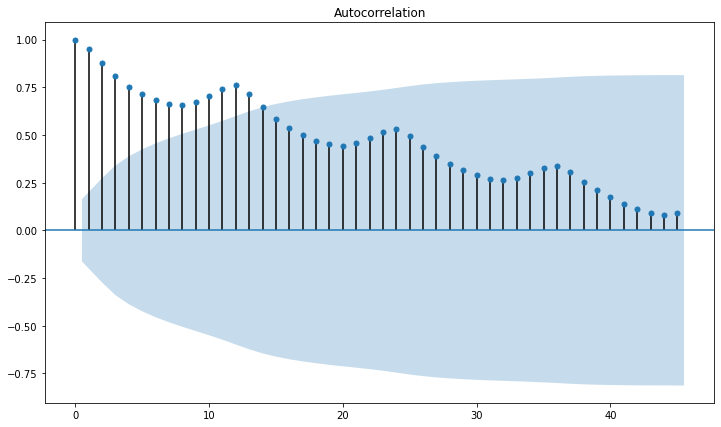

In [3]:
from statsmodels.graphics import tsaplots
fig, ax = plt.subplots(figsize = (12,7))
# Display the autocorrelation plot of your time series
fig = tsaplots.plot_acf(dataset.passengers, lags=45, ax = ax)

reforzando el entendimiento de lo anterior,en la grafica podemos ver lo siguiente:
1. cuando hay un lag = 5 (es decir evaluar que tan relacionadas estas las 5 muestras anteriores), tenemos una autocorrelación $\approx$ 0.75 
2. cuando hay un lag = 25 (es decir evaluar que tan relacionadas estas las 25 muestras anteriores), tenemos una autocorrelación $\approx$ 0.5

Ten en cuenta este analisis para responder la siguiente pregunta abierta

In [4]:
#@title Pregunta Abierta
#@markdown ¿Por qué es mas factible construir un modelo RNN con un retardo de 5 vs un retardo de 25? . Justifica con base a las anteriores explicaciones
respuesta_1 = "Dado que generalmente la correlacion entre cada retardo no es constante, sino que varia a lo largo del tiempo y esta variacion se de forma paulatina, asi que es mas factible escoger un retardo de 5, ya que va  haber mayor probabilidad de que el valor de correlacion no haya cambiado mucho comparado con uno de 25" #@param {type:"string"}

Para aplicar la red recurrente, debemos transformar nuestros datos. La idea es alimentar los retrasos como caracteristicas a nuestro modelo. Para ello se propone esta función.

In [5]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    """funcion que crea dataset apto para RNN
    
    dataset: pandas dataframe con una sola columna
    look_back: numero de retrasos con los cuales queremos construir
        las caracteristicas
    """
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY).reshape(len(dataY), 1)

## Ejercicio 2 - Experimentar con RNN

Vamos usar una libreria llamada neurolab. La documentación puede ser consultada en : https://pythonhosted.org/neurolab/. (podemos hacer uso como `nl...`)

En el siguiente ejercicio vamnos a completar el código para entrenar una red neuronal recurrente de Elman con las siguientes caracteristicas:
1. las capas ocultas deben ser variables de acuerdo al parametro. Sin embargo solo siempre tenemos una sola capa de salida.
2. función de activación tangente hiperbólica paras las capas ocultas y lineal para la capa de salida. 
3. número de épocas igual a 1000.
4. Definir objetivo de error inferior a 0.001. 
5. Inicializar los pesos de las capas aleatoriamente entre [-0.1, 0.1].
6. Vamos utilizar como medida de error el error absoluto medio.  [recordar usar la implementación del modulo de metricas de sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

Notas Adicionales:
1. tener en cuenta que hace el parametro feature_range de la función [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
2. Entender como se sugiere usar la codigo que vamos encontrar dentro la función:
```python
layers = []
    for i in range(look_back):
        layers.append([0, 1])
```

In [6]:
#ejercicio de código
def experimentar_elman(data, look_backs, hidden_neurons):
    """funcion que realiza experimentos para evaluar una RNN de elman usando
        el error absoluto medio como medida de error
    
    data: pd.Dataframe, dataset a usar
    look_back: List[int], lista con los numero de retrasos a evaluar
    hidden_neurons: List[int], list con el numero de neuronas en la capa oculta
    retorna: pd.Dataframe con las siguientes columnas:
        - lags
        - neuronas por capas
        - error de entrenamiento
        - error de prueba
    """
    # we need to normalize the dataset before
    #
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(data)
    # split into train and test sets
    train_size = int(len(dataset) * 0.7)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    resultados = pd.DataFrame()
    idx = 0
    for num_hidden_neurons in hidden_neurons:
        for look_back in look_backs:
            # reshape into X=t-look_back+1:t and Y=t+1
            trainX, trainY = create_dataset(train, look_back)
            testX, testY = create_dataset(test, look_back)          
            #Esta variable se requiere para definir la red de acuerdo con la librería neurolab. 
            #Define el número de entradas y el rango de valores que toma cada entrada
            layers = []
            for i in range(look_back):
                layers.append([0, 1])
            # Crear la red usa una instruccion como nl.{...}.{...}
            net = nl.net.newelm( layers,[num_hidden_neurons,1], [nl.trans.TanSig(), nl.trans.PureLin()])
            #definir funciones para inicializar los pesos e inicializar la red
            # Set initialized functions and init
            net.layers[0].initf = nl.init.InitRand([-0.1, 0.1], 'w')
            net.layers[1].initf= nl.init.InitRand([-0.1, 0.1], 'w')
            net.init()
            # Entrenar la red con los datos de entrenamiento
            # la instrucción del tiempo es para evaluar el tiempo
            # de entrenamiento, llame explícitamente los parametros
            # para las epocas y el objetivo
            # show = 500 # (esta instruccion ayuda a que no se presenten muchos prints intermedios)
            net.train(trainX,trainY,epochs=1000, show=500, goal=0.001)
            # Evaluar la red con los datos de en entrenamiento y test
            trainYPred = net.sim(trainX)
            testYPred = net.sim(testX)
            # Calculo de error
            errorPrueba = mean_absolute_error(testY,testYPred)
            errorEntrenamiento = mean_absolute_error(trainY, trainYPred)
            resultados.loc[idx,'lags'] = look_back
            resultados.loc[idx,'neuronas por capa'] = num_hidden_neurons
            resultados.loc[idx,'error de entrenamiento'] = errorEntrenamiento
            resultados.loc[idx,'error de prueba'] = errorPrueba
            idx+=1
    
    return (resultados)

In [7]:
#
GRADER.run_test("ejercicio1", experimentar_elman)

Epoch: 500; Error: 0.061405491482501164;
Epoch: 1000; Error: 0.06285819323872047;
The maximum number of train epochs is reached
Epoch: 500; Error: 0.063246181145608;
Epoch: 1000; Error: 0.06324623786660663;
The maximum number of train epochs is reached
Epoch: 500; Error: 0.06140457786629572;
Epoch: 1000; Error: 0.0648334157276388;
The maximum number of train epochs is reached
Epoch: 500; Error: 0.06324620957596791;
Epoch: 1000; Error: 0.06719199656084511;
The maximum number of train epochs is reached
TEST EXITOSO!


Ahora vamos a ver los resultados del experimentos, variando los lags y las neuronas por capa

In [8]:
resultadosElman = experimentar_elman(dataset, look_backs = [1,3,5,10,30,40], hidden_neurons=[10,20,30])

Epoch: 500; Error: 0.01966988953199409;
Epoch: 1000; Error: 0.021251413967500573;
The maximum number of train epochs is reached
Epoch: 500; Error: 0.002622075246755581;
Epoch: 1000; Error: 0.002079187774923365;
The maximum number of train epochs is reached
Epoch: 500; Error: 0.019068011956791787;
Epoch: 1000; Error: 0.019145344697706995;
The maximum number of train epochs is reached
Epoch: 500; Error: 0.01852192706913856;
Epoch: 1000; Error: 0.018523949219079197;
The maximum number of train epochs is reached
Epoch: 500; Error: 0.013831783180013291;
Epoch: 1000; Error: 0.014123445813445656;
The maximum number of train epochs is reached
Epoch: 500; Error: 0.01212095346878179;
Epoch: 1000; Error: 0.012132964049858547;
The maximum number of train epochs is reached
Epoch: 500; Error: 0.015193998323137557;
Epoch: 1000; Error: 0.010697706937245845;
The maximum number of train epochs is reached
Epoch: 500; Error: 0.019388693404372482;
Epoch: 1000; Error: 0.01939272552461736;
The maximum number

In [9]:
# para ver los resultados
# en esta instruccion se va resaltar el mejor
# error y tiempo de entrenamiento
resultadosElman.style.highlight_min(color = 'lightgreen', axis = 0, subset = ['error de prueba'])

,lags,neuronas por capa,error de entrenamiento,error de prueba
0,1.000000,10.000000,0.122904,0.354553
1,3.000000,10.000000,0.037092,0.078274
2,5.000000,10.000000,0.114774,0.374397
3,10.000000,10.000000,0.111526,0.399293
4,30.000000,10.000000,0.095011,0.431163
5,40.000000,10.000000,0.089634,0.371868
6,1.000000,20.000000,0.077477,0.245548
7,3.000000,20.000000,0.115805,0.386494
8,5.000000,20.000000,0.114469,0.381537
9,10.000000,20.000000,0.111554,0.396823


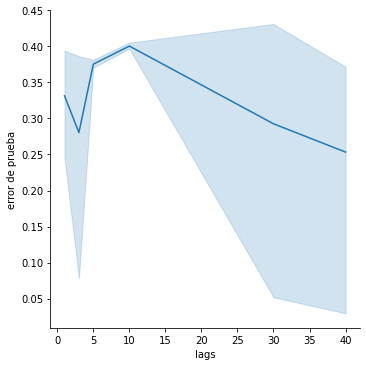

In [10]:
# observa el comportamiento de los lags
import seaborn as sns
sns.relplot(data= resultadosElman, x= 'lags', y = 'error de prueba', kind = 'line')

In [11]:
#@title Pregunta Abierta
#@markdown ¿Por qué seguir aumentando los tiempos de retardo no implica siempre una mejora en la predicción del modelo?
respuesta_2 = "Porque la aplicacion consecutiva de multiples funciones de activacion, pueden terminar por desvanecer el resultado, por lo tanto el error de prueba volveria aumentar" #@param {type:"string"}

## Ejercicio 3 - Comparación con MLP

En este ejercicio vamos a realizar el mismo ejercicio, pero con un MLP. Con esto vamos a comparar los resultados obtenidos con la RNN.

Para ellos vamos a :
1. variar los retrasos, que corresponden a las neuronas en la capa de entrada
2. vamos a dejar solo una capa oculta y vamos a variar el número de neuronas en esta capa
3. el número de epocas también va ser de 1000
4. el valor por defecto sera usado para el resto de parámetros
5. utilizar como medida de error el error absoluto medio.  [recordar usar la implementación del modulo de metricas de sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

In [12]:
#@title Pregunta Abierta
#@markdown ¿explique la principal diferencia entre un MLP y una red recurrente de elman? justificar usando usando como contexto el problema que estamos resolviendo.
respuesta_3 = "La principal diferencia es que una red recurrente de elman la salida de las capas ocultas se van a a conectar a la entrada de la misma capa oculta pero un tiempo posterior. En el caso del problema, en un mes poterior. En cambio en un MLP, no le importa que los datos sean secuenciales, se asume que cada muestra es independiente" #@param {type:"string"}

In [13]:
#ejercicio de código
def experimentar_MLP(data, look_backs, hidden_neurons):
    """funcion que realiza experimentos para evaluar una MLPusando
        MAPE como medida de error
    
    data: pd.Dataframe, dataset a usar
    look_back: List[int], lista con los numero de retrasos a evaluar
    hidden_neurons: List[int], list con el numero de neuronas en la capa oculta
    retorna: pd.Dataframe con las siguientes columnas:
        - lags
        - neuronas por capas
        - error de entrenamiento
        - error de prueba
    """
    # we need to normalize the dataset before
    #
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(data)
    # split into train and test sets
    train_size = int(len(dataset) * 0.7)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    resultados = pd.DataFrame()
    idx = 0
    for num_hidden_neurons in hidden_neurons:
        for look_back in look_backs:
            # reshape into X=t-look_back+1:t and Y=t+1
            trainX, trainY = create_dataset(train, look_back)
            testX, testY = create_dataset(test, look_back)          
            # define el MLP para Regresion pasando los parametros adecuados
            # pasar random_state = 10 para lograr resultados reproducibles
            net =  MLPRegressor(hidden_layer_sizes= (num_hidden_neurons,1), max_iter = 1000, random_state = 10)
            # Entrenar la red con los datos de entrenamiento
            net.fit(X=trainX, y=trainY)
            # Evaluar la red con los datos de entrenamiento y test
            trainYPred = net.predict(trainX)
            testYPred = net.predict(testX)
            # Calculo de error
            errorPrueba = mean_absolute_error(testY, testYPred)
            errorEntrenamiento =mean_absolute_error(trainY, trainYPred)
            resultados.loc[idx,'lags'] = look_back
            resultados.loc[idx,'neuronas por capa'] = num_hidden_neurons
            resultados.loc[idx,'error de entrenamiento'] = errorEntrenamiento
            resultados.loc[idx,'error de prueba'] = errorPrueba
            idx+=1
    
    return (resultados)

In [14]:
GRADER.run_test("ejercicio2", experimentar_MLP)

TEST EXITOSO!


In [15]:
resultadosMLP = experimentar_MLP(dataset, look_backs = [1,3,5,10,30,40], hidden_neurons=[10,20,30])

In [16]:
# para ver los resultados
# en esta instruccion se va resaltar el mejor
# error y tiempo de entrenamiento
resultadosMLP.style.highlight_min(color = 'lightgreen', axis = 0, subset = ['error de prueba'])

,lags,neuronas por capa,error de entrenamiento,error de prueba
0,1.000000,10.000000,0.407783,0.123787
1,3.000000,10.000000,0.129331,0.513968
2,5.000000,10.000000,0.214258,0.597153
3,10.000000,10.000000,0.751661,1.152376
4,30.000000,10.000000,0.698707,1.112792
5,40.000000,10.000000,0.607945,0.974479
6,1.000000,20.000000,0.074414,0.316314
7,3.000000,20.000000,0.055649,0.138220
8,5.000000,20.000000,0.114254,0.386620
9,10.000000,20.000000,0.217318,0.198351


## Ejercicio 4 - Comparación con LSTM

En nuestro ultimo ejercicio, vamos a comparar los resultados obtenidos hasta ahora con una LSTM, Para ellos vamos a usar una libreria llamada [Tensorflow](https://www.tensorflow.org/?hl=es-419). Esta libreria es unos de las librerias estandares para entrenar redes neuronales (hay otras librerias cada vez más populares, [PyTorch](https://pytorch.org/)). En un entorno real es preferible usar algunas de estas librerias para trabajar con redes neuronales.

Nota: en el alcance del curso no vamos a ver detalles de como crear modelos con estas librerias. Estos temas corresponden a temas más avanzados de Deep Learning. En el código se usan conceptos que nos vamos a profundizar, sin embargo se invita a alimentar la curiosidad.

In [17]:
#@title Pregunta Abierta
#@markdown ¿por qué una red LSTM puede ser mas adecuada para resolver este problema? justifique
respuesta_4 = "Dado que la secuencia es demasiado larga, tiene alrededor de 11 a\xF1os y es por meses, LSTM va a ser mas adecuada ya que tiene la capacidad de aprender, de tiempo corto, largo y asi mismo de decir cuando olvidar. Asi que seria adecuado este modelo para el problema, ya que se necesita aprender dependencias de orden superior en los datos" #@param {type:"string"}

Aca creamos el modelo LSTM usando tensorflow:

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
def create_tf_model(look_back, num_hidden_neurons):
    """funcion que crear modelo LSTM con base al número de lags y numero de neuronas"""
    model = Sequential()
    model.add(LSTM(num_hidden_neurons, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

Vamos aseguranos de completar el código para lograr:
1. Epocas = 100
2. Pasar los parametros el la función `create_tf_model`
3. utilizar como medida de error el error absoluto medio.  [recordar usar la implementación del modulo de metricas de sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

In [19]:
#ejercicio de código
import tensorflow as tf
def experimentar_LSTM(data, look_backs, hidden_neurons):
    """funcion que realiza experimentos para evaluar una LSTM usando
        MAE Error Absoluto medio
    
    data: pd.Dataframe, dataset a usar
    look_back: List[int], lista con los numero de retrasos a evaluar
    hidden_neurons: List[int], list con el numero de neuronas en la capa oculta
    retorna: pd.Dataframe con las siguientes columnas:
        - lags
        - neuronas por capas
        - error de entrenamiento
        - error de prueba
    """
    # we need to normalize the dataset before
    #
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(data)
    # split into train and test sets
    train_size = int(len(dataset) * 0.7)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    resultados = pd.DataFrame()
    idx = 0
    for num_hidden_neurons in hidden_neurons:
        for look_back in look_backs:
            # reshape into X=t-look_back+1:t and Y=t+1
            trainX, trainY = create_dataset(train, look_back)
            testX, testY = create_dataset(test, look_back)
            # adaptar para compatibilidad con tensorflow
            trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
            testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
            tf.compat.v1.disable_eager_execution() # para evitar algunos warnings
            # llama la función definida anteriormente
            model = create_tf_model(look_back, num_hidden_neurons)
            # pasa el las epocas requeridas
            model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=None)
            # Evaluar la red con los datos de test y entrenamiento 
            trainYPred = model.predict(trainX)
            testYPred = model.predict(testX)
            # Calculo de error
            errorTrain = mean_absolute_error(trainY, trainYPred)
            errorTest = mean_absolute_error(testY, testYPred)
            resultados.loc[idx,'lags'] = look_back
            resultados.loc[idx,'neuronas por capa'] = num_hidden_neurons 
            resultados.loc[idx,'error de entrenamiento'] = errorTrain
            resultados.loc[idx,'error de prueba'] = errorTest
            idx+=1
            print("termina un experimento con", errorTrain, errorTest)
    
    return (resultados)

In [20]:
# ignorar los prints!
GRADER.run_test("ejercicio3", experimentar_LSTM)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
termina un experimento con 0.1639784905136295 0.3305947303662056
termina un experimento con 0.1454812713498109 0.3727200704287421
TEST EXITOSO!


In [21]:
# demora algunos minutos!
resultadosLSTM = experimentar_LSTM(dataset, look_backs = [1,3,5,20,30,40], hidden_neurons=[5,10,15])

termina un experimento con 0.03575034006874116 0.08185619664314939
termina un experimento con 0.036971094701795354 0.08544109873905145
termina un experimento con 0.03975264122269716 0.06746004636913652
termina un experimento con 0.016094035759985508 0.047565192304362736
termina un experimento con 0.013326875794168015 0.028481004391787187
termina un experimento con 0.020531120798630068 0.029996948582785454
termina un experimento con 0.03547494369909401 0.08305426277555862
termina un experimento con 0.03829853348977843 0.07520371860749013
termina un experimento con 0.03507917745554985 0.07686432172275369
termina un experimento con 0.015139648381577494 0.030114622850115503
termina un experimento con 0.012492663091057248 0.03904688813263632
termina un experimento con 0.012566936225933542 0.060280721850376806
termina un experimento con 0.03566846456325861 0.08347782473459822
termina un experimento con 0.03407630469962456 0.09014758071268847
termina un experimento con 0.03677895194809931 0.0

In [22]:
# para ver los resultados
# en esta instruccion se va resaltar el mejor
# error y tiempo de entrenamiento
resultadosLSTM.style.highlight_min(color = 'lightgreen', axis = 0, subset = ['error de prueba'])

,lags,neuronas por capa,error de entrenamiento,error de prueba
0,1.000000,5.000000,0.035750,0.081856
1,3.000000,5.000000,0.036971,0.085441
2,5.000000,5.000000,0.039753,0.067460
3,20.000000,5.000000,0.016094,0.047565
4,30.000000,5.000000,0.013327,0.028481
5,40.000000,5.000000,0.020531,0.029997
6,1.000000,10.000000,0.035475,0.083054
7,3.000000,10.000000,0.038299,0.075204
8,5.000000,10.000000,0.035079,0.076864
9,20.000000,10.000000,0.015140,0.030115


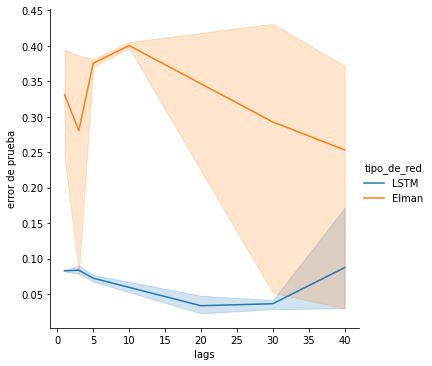

In [23]:
# observa el comportamiento de los lags y comparar con elman
import seaborn as sns
resultadosLSTM['tipo_de_red'] = 'LSTM'
resultadosElman['tipo_de_red'] = 'Elman'
lstm_vs_elman = pd.concat([resultadosLSTM, resultadosElman], axis= 0 , ignore_index = True)
sns.relplot(data= lstm_vs_elman, x= 'lags', y = 'error de prueba', kind = 'line', hue = 'tipo_de_red')

In [27]:
GRADER.check_tests()

Todo se ve ok. Asegurate de responder las preguntas abiertas y envia e archivo al formulario ¡buen trabajo!


In [25]:
#@title Integrantes
codigo_integrante_1 ='1017251689' #@param {type:"string"}
codigo_integrante_2 = ''  #@param {type:"string"}

----
esta linea de codigo va fallar, es de uso exclusivo de los profesores


In [26]:
GRADER.grade()

uso del docente
